In [1]:
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
import geopandas as gpd

test_df = pd.read_excel("C:/Users/lilia/Documents/GitHub/WMCA/DSSG_WMCA/data/external/Solar PV installations west midlands.xlsx", sheet_name="Sheet3")
test_df['Postcode'] = test_df['Postcode'].str.upper()
test_df = test_df[test_df['Postcode'].isna()==False]

test_add_cols = ['Address Line 1', 'Address Line 2', 'Address Line 3']
test_df[test_add_cols] = test_df[test_add_cols].fillna('')
test_df['full_address'] = test_df[test_add_cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

c:\Users\lilia\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
def add_full_address(db):
    db['buildingNumber'] = db['buildingNumber'].astype('Int64').astype(str)
    db['buildingNumber'] = db['buildingNumber'].str.replace("<NA>", "")
    db['postcode'] = db['postcode'].str.replace(r"\s", "")

    results_add_cols = ['buildingNumber', 'thoroughfare']
    db[results_add_cols] = db[results_add_cols].fillna('')
    db['full_address'] = db[results_add_cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
    db = db[db['full_address'] !='']

    return db

In [3]:
irradiance_df = pd.read_csv("C:/Users/lilia/Documents/GitHub/WMCA/DSSG_WMCA/data/processed/irradiance.csv", index_col=0)
irradiance_df.index = irradiance_df.index.astype(int)
irradiance_df.columns = irradiance_df.columns.astype(int)

def add_kk_factor(db, irradiance_df):
    kk_factor = []
    for idx, row in db.iterrows():
        aspect = abs(row['aspect_mean'] - np.pi) * 180 / np.pi
        if 0 <= aspect <= 176 and 0 <= row['slope_mean'] < 90:
            aspect = 5 * round(aspect/5) # round to nearest 5
            slope = round(row['slope_mean'])
            if 0 < slope <= 10:
                kk_factor.append(irradiance_df.max().max())
            else:
                kk_factor.append(int(irradiance_df[aspect][slope]))
        else:
            kk_factor.append(0)

    return kk_factor

In [4]:
def get_test_set(test_df, train_df):
    unq_postcode = list(train_df.postcode.unique())

    uprn = {}
    mapped_add = {}
    score = {}
    for postcode, grp in test_df.groupby('Postcode'): 
        if postcode in unq_postcode:
            sub_results = train_df[train_df.postcode==postcode]
            for i in grp.index:
                if sub_results['full_address'].shape[0]:
                    fuzz_score = [fuzz.partial_ratio(grp['full_address'][i], add) for add in sub_results['full_address']]
                    idx = sub_results.index[np.argmax(np.array(fuzz_score))]
                    if max(fuzz_score) > 80:
                        uprn[i] = sub_results['uprn'][idx]
                        mapped_add[i] = sub_results['full_address'][idx]
                        score[i] = max(fuzz_score)

    matched_uprn = test_df.loc[uprn.keys()]
    matched_uprn['uprn'] = uprn.values()
    matched_uprn['mapped_address'] = mapped_add.values()
    matched_uprn['score'] = score.values()

    if len(matched_uprn) > 0:
        matched_uprn = matched_uprn.merge(
            train_df, 
            how='left', on='uprn'
            )
    else:
        print("No matches")

    return matched_uprn

In [8]:
pvlib_roof_segment = pd.read_csv("C:/Users/lilia/Documents/GitHub/WMCA/DSSG_WMCA/scripts/calc_pv_output/output/roof_segment_pv.csv")
pvlib_roof_segment = add_full_address(pvlib_roof_segment)
data = get_test_set(test_df, pvlib_roof_segment)

C:\Users\lilia\AppData\Local\Temp\ipykernel_19220\3026001523.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  db['postcode'] = db['postcode'].str.replace(r"\s", "")


No matches


In [7]:
MCS_pv_output = pd.read_csv("C:/Users/lilia/Documents/GitHub/WMCA/DSSG_WMCA/scripts/calc_pv_output/output/MCS_pv_output.csv")
MCS_pv_output = add_full_address(MCS_pv_output)
data = get_test_set(test_df, MCS_pv_output)

C:\Users\lilia\AppData\Local\Temp\ipykernel_19220\3026001523.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  db['postcode'] = db['postcode'].str.replace(r"\s", "")


No matches


In [5]:
MCS_pv_output['pv_output'].describe()

count       5.000000
mean     4511.059343
std      2423.144277
min      2741.444969
25%      2741.444969
50%      2741.444969
75%      7165.480904
max      7165.480904
Name: pv_output, dtype: float64

In [ ]:
no_DSM = pd.read_csv("output/SJ9000_results.csv")
no_DSM = add_full_address(no_DSM)

In [5]:
pvlib_building = pd.read_csv("C:/Users/lilia/Documents/GitHub/WMCA/DSSG_WMCA/scripts/calc_pv_output/output/building_pv.csv")
pvlib_building = add_full_address(pvlib_building)
data = get_test_set(test_df, pvlib_building)
data[['Estimated Annual Generation', 'pv_output']].describe()

C:\Users\lilia\AppData\Local\Temp\ipykernel_19220\3026001523.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  db['postcode'] = db['postcode'].str.replace(r"\s", "")


,Estimated Annual Generation,pv_output
count,542.000000,5.420000e+02
mean,2816.828930,1.845081e+07
std,3091.303542,7.478945e+07
min,1.820000,2.072375e+06
25%,1749.552500,5.144183e+06
50%,2564.500000,6.622436e+06
75%,3235.000000,9.641085e+06
max,42090.000000,1.597485e+09


In [85]:
og_df = gpd.read_file("C://Users//lilia//Downloads//wmca_download_2022-07-29_10-07-36//files//wmca_prj//project//unzip_files//output//SJ9000.geojson", driver="GeoJSON")
mapping = dict(zip(og_df['uprn'], og_df['parentUPRN']))

In [90]:
pv_output['parentUPRN'] = pv_output['uprn'].map(mapping)

In [107]:
nested_buildings = pv_output[pv_output['parentUPRN'].isna()==False]
nested_buildings.groupby('uprn').sum()['AC'].describe()

count        34.000000
mean     222810.941162
std      103235.823566
min        5967.630725
25%      273287.769168
50%      273287.769168
75%      273287.769168
max      273287.769168
Name: AC, dtype: float64

In [106]:
unnested_buildings = pv_output[pv_output['parentUPRN'].isna()==True]
unnested_buildings.groupby('uprn').sum()['AC'].describe()

count       441.000000
mean      36829.340972
std       38288.158250
min        2010.391400
25%       12739.773021
50%       26551.113135
75%       43270.215642
max      273287.769168
Name: AC, dtype: float64

In [83]:
pv_output.groupby('uprn').sum()['AC'].describe()

count       475.000000
mean      50141.708143
std       66379.975122
min        2010.391400
25%       13017.885623
50%       28512.724403
75%       46910.120384
max      273287.769168
Name: AC, dtype: float64

In [70]:
test_df['Estimated Annual Generation'].describe()

count    6.028200e+04
mean     2.439131e+07
std      5.987197e+09
min      0.000000e+00
25%      1.200000e+03
50%      2.439000e+03
75%      3.286400e+03
max      1.470000e+12
Name: Estimated Annual Generation, dtype: float64

In [263]:
m = pv_output.uprn.isin(matched_uprn.uprn)
pv_output[m]

,gml_id,fid,featureCode,versionDate,calculatedAreaValue,RelH2,RelHMax,AbsHMin,height_mean,AbsH2,...,buildingNumber,thoroughfare,postTown,postcode,level,shading_mean,geometry,lng,lat,pv_output
14,uk.addressbase.uprn.100071134104,osgb1000024564118,10021,2016-10-24,44.951303,104.1,109.4,110.6,5.3,6.5,...,7.0,ALVERSTOKE CLOSE,WOLVERHAMPTON,WV9 5PS,NaN,1.000000,POLYGON ((-2.1482988406912558 52.6206253075970...,-2.148333,52.620573,167278.846809
18,uk.addressbase.uprn.100071558168,osgb1000024873103,10021,2017-03-23,65.657878,143.5,148.3,150.8,4.8,7.3,...,19.0,HYLSTONE CRESCENT,WOLVERHAMPTON,WV11 3EX,NaN,1.000000,POLYGON ((-2.0759278048489103 52.6050163032218...,-2.075975,52.605034,167278.846809
28,uk.addressbase.uprn.10093327557,osgb5000005269986808,10021,2020-09-21,49.371695,149.7,156.4,157.3,6.7,7.6,...,9.0,KEN PURCHASE GARDENS,WOLVERHAMPTON,WV10 8AL,NaN,1.000000,POLYGON ((-2.097706652145619 52.61736338954055...,-2.097746,52.617406,167278.846809
33,uk.addressbase.uprn.10090642146,osgb5000005207351496,10021,2017-07-13,44.676697,142.7,148.3,150.8,5.6,8.1,...,41.0,JENNIE LEE AVENUE,WOLVERHAMPTON,WV11 3LZ,NaN,1.000000,POLYGON ((-2.0768893654216947 52.6025117060615...,-2.076967,52.602526,167278.846809
37,uk.addressbase.uprn.100071160061,osgb1000024562728,10021,2016-12-15,70.767225,114.2,119.4,121.8,5.2,7.6,...,62.0,GLAISDALE GARDENS,WOLVERHAMPTON,WV6 0TU,NaN,0.898704,POLYGON ((-2.1458646254273446 52.5994409292420...,-2.145840,52.599383,150334.227712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29770,uk.addressbase.uprn.10093326375,osgb5000005238326383,10021,2018-11-02,57.527942,132.2,138.5,141.6,6.3,9.4,...,174.0,FIFTH AVENUE,WOLVERHAMPTON,WV10 9ST,NaN,1.000000,POLYGON ((-2.1193930484854335 52.6078639216653...,-2.119452,52.607898,167278.846809
29891,uk.addressbase.uprn.100071183848,osgb1000024725687,10021,2017-02-07,60.232591,139.4,143.6,148.1,4.2,8.7,...,174.0,PARK LANE,WOLVERHAMPTON,WV10 9QL,NaN,0.892562,POLYGON ((-2.1082244326780164 52.6052402698451...,-2.108303,52.605266,149306.738888
29993,uk.addressbase.uprn.10093326952,osgb5000005238807394,10021,2018-11-14,318.140727,110.8,115.1,116.3,4.3,5.5,...,907.0,STAFFORD ROAD,WOLVERHAMPTON,WV10 7ER,NaN,0.953660,POLYGON ((-2.125840109243255 52.63664844209143...,-2.125695,52.636551,159527.166502
30011,uk.addressbase.uprn.100071208076,osgb1000024872649,10021,2006-10-23,45.089864,147.2,152.6,155.5,5.4,8.3,...,30.0,WOOD END ROAD,WOLVERHAMPTON,WV11 1NR,NaN,1.000000,POLYGON ((-2.0797555404530086 52.6044205444986...,-2.079831,52.604408,167278.846809


In [166]:
import geopandas as gpd
roof_segment = gpd.read_file("C:/Users/lilia/Documents/GitHub/WMCA/DSSG_WMCA/scripts/calc_pv_output/output/sj9000_DSM_1M.geojson", driver="GeoJSON")

In [122]:
roof_segment.dropna()

,fid,slope,fid_2,aspect,slope_mean,aspect_mean,height_mean,shading_mean,AREA,geometry
0,2,4,3,2,70.319947,1.417046,131.069000,0.750000,10.259740,"MULTIPOLYGON (((390642.968 300996.985, 390642...."
5,69,4,70,1,55.173542,5.904582,138.279285,0.488095,35.423087,"MULTIPOLYGON (((390977.926 300899.978, 390977...."
6,71,4,71,4,65.160565,4.922692,136.682499,0.395833,8.160979,"MULTIPOLYGON (((390973.000 300899.161, 390973...."
8,80,4,83,1,56.346479,4.968493,138.147307,0.576923,22.060220,"MULTIPOLYGON (((390966.812 300893.000, 390966...."
14,93,1,88,4,65.892725,4.173050,137.175003,0.770833,8.459018,"MULTIPOLYGON (((390952.000 300885.188, 390952...."
...,...,...,...,...,...,...,...,...,...,...
2749,4060,4,5345,4,61.434688,4.188068,125.142500,0.687500,7.169722,"MULTIPOLYGON (((390050.000 300019.161, 390050...."
2750,4060,4,5350,1,55.819908,4.188068,125.142500,0.687500,6.150086,"MULTIPOLYGON (((390048.985 300017.032, 390048...."
2751,4060,4,5470,4,68.892535,4.188068,125.142500,0.687500,75.151978,"MULTIPOLYGON (((390040.454 300011.911, 390040...."
2752,4060,4,5550,4,60.448362,4.188068,125.142500,0.687500,26.972795,"MULTIPOLYGON (((390035.495 300003.952, 390035...."


{'whiskers': [<matplotlib.lines.Line2D at 0x17cacabbdc0>,
 'caps': [<matplotlib.lines.Line2D at 0x17cacac2460>,
 'boxes': [<matplotlib.lines.Line2D at 0x17cacabb970>],
 'medians': [<matplotlib.lines.Line2D at 0x17cacac2b80>],
 'fliers': [<matplotlib.lines.Line2D at 0x17cacac2f10>],
 'means': []}

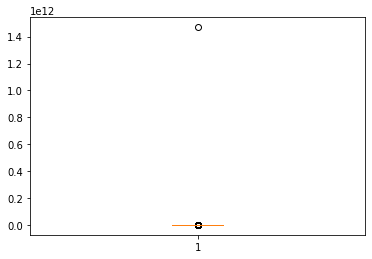

In [6]:
import matplotlib.pyplot as plt
plt.boxplot(df['Estimated Annual Generation'])